In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

## Load Dataset

In [ ]:
df = pd.read_csv("../output.csv")

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
# df.drop("ID", axis=1, inplace=True)
# df.head()

## Data Imputation

In [ ]:
from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy='median')
#
# df.replace(999, np.nan, inplace=True)
#
# df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [ ]:
df.describe()

In [ ]:
import seaborn as sns

print(df['pCR (outcome)'].value_counts())
sns.countplot(x="pCR (outcome)", data=df)

## Splitting X and Y Dataframes

In [ ]:
y_class = df["pCR (outcome)"]
y_reg = df["RelapseFreeSurvival (outcome)"]
# Aidan tag
df.drop("pCR (outcome)", axis=1, inplace=True)
df.drop("RelapseFreeSurvival (outcome)", axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
X_clinical = df.iloc[:, :11]
X_mri = df.iloc[:, 11:]

## Recursive Feature Elimination (RFE) on Clinical Features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

model_all = RandomForestClassifier(random_state=42)
model_all.fit(X_clinical, y_class)

all_importances = model_all.feature_importances_
indices = np.argsort(all_importances)[::-1]

plt.figure()
plt.title("Feature Importances of All Clinical Features")
plt.bar(X_clinical.columns[indices], all_importances[indices], color="lightsalmon", align="center")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
model = RandomForestClassifier(random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_clinical, y_class)

selected_features = X_clinical.columns[rfecv.support_]
print("Optimal Number of Features:", rfecv.n_features_)
print("Selected Features:")
print(selected_features)

In [ ]:
X_clinical_fs = X_clinical[selected_features]

## Dimensionality Reduction on MRI Features

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_mri_dr = pca.fit_transform(X_mri)

print("Number of Components Selected:", pca.n_components_)

In [ ]:
print(X_clinical_fs.shape, type(X_clinical_fs))
print(X_mri_dr.shape, type(X_mri_dr))

In [ ]:
X = np.hstack((X_clinical_fs.values, X_mri_dr))
X_pd = pd.DataFrame(X)
# Aidan tag, output the data after feature selection into a file
combined_df = pd.concat([y_reg, X_pd], axis=1)
combined_df.drop(columns=0, inplace=True)
combined_df.to_csv('output_after_feature_selection.csv')

In [ ]:
X.shape, type(X.shape)

((400, 11), tuple)

In [ ]:
print(y_class.value_counts())
#sns.countplot(x="pCR (outcome)", data=df)

pCR (outcome)
0.0    316
1.0     84
Name: count, dtype: int64


## Z-score Distribution

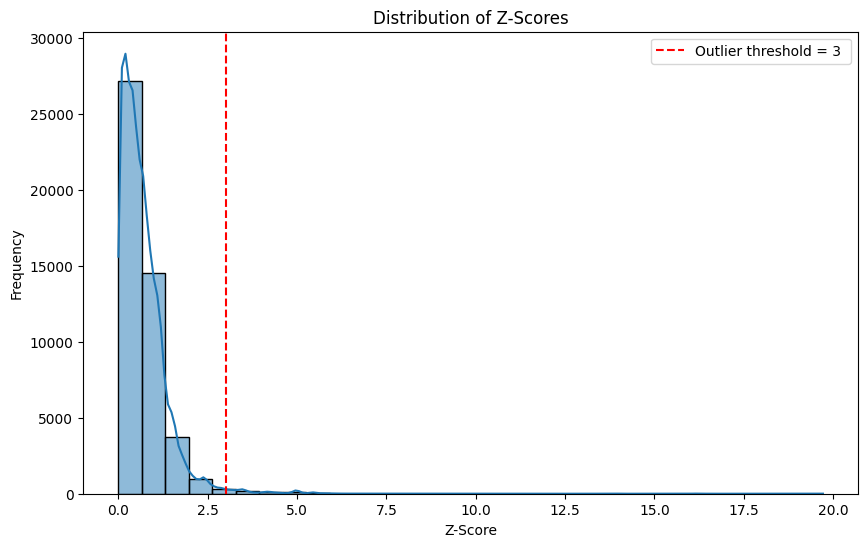

In [ ]:
from scipy.stats import zscore

z_scores = np.abs(zscore(df))
z_scores = z_scores.to_numpy()
z_scores_flat = z_scores.flatten()

plt.figure(figsize=(10, 6))
sns.histplot(z_scores_flat, bins=30, kde=True)
plt.title("Distribution of Z-Scores")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.axvline(x=3, color='r', linestyle='--', label="Outlier threshold = 3 ")
plt.legend()
plt.show()

## Data Splitting

In [ ]:
#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.30, random_state=42, stratify=y_class)

# Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


# Calculate class weights
class_counts = np.bincount(y_train.astype(int))
total_samples = len(y_train)
num_classes = len(class_counts)

class_weights = {}
for i, count in enumerate(class_counts):
    class_weights[i] = total_samples / (num_classes * count)

# Assign weights to each sample
sample_weights = []
for label in y_train:
    sample_weights.append(class_weights[int(label)])
sample_weights = np.array(sample_weights)

gbc = GradientBoostingClassifier(random_state=42, loss='log_loss', subsample=0.8, n_estimators=100, learning_rate=0.1, max_depth=3)
gbc.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = gbc.predict(X_test)

print("Classification Report before SMOTE:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report before SMOTE:
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83        95
         1.0       0.39      0.44      0.42        25

    accuracy                           0.74       120
   macro avg       0.62      0.63      0.62       120
weighted avg       0.75      0.74      0.75       120

Confusion Matrix:
[[78 17]
 [14 11]]


## ROC Curve

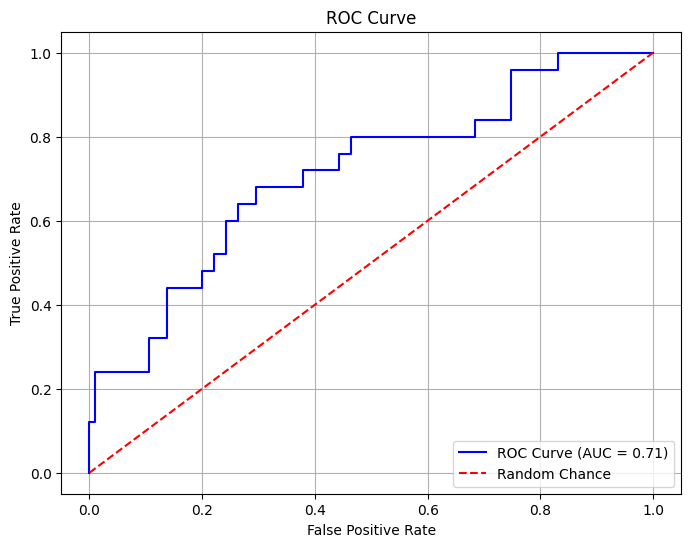

In [ ]:
# Calculate ROC curve
y_pred_proba = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## RFC

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
print("Classification Report before SMOTE:")
print(report)

Model Accuracy: 0.7583333333333333
Classification Report before SMOTE:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86        95
         1.0       0.33      0.16      0.22        25

    accuracy                           0.76       120
   macro avg       0.57      0.54      0.54       120
weighted avg       0.71      0.76      0.72       120



## SMOTE

Reference from : https://towardsdatascience.com/upsampling-with-smote-for-classification-projects-e91d7c44e4bf

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE( sampling_strategy = 1.0, random_state=42)
X_resampled, y_resampled = smote.fit_resample(
    X_train, y_train)
# Check the class distribution after applying SMOTE
print(pd.Series(y_resampled).value_counts())

pCR (outcome)
0.0    221
1.0    221
Name: count, dtype: int64


## GridSearchCV

In [73]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'subsample': [0.8, 1.0],
}

model = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

print("Performing GridSearchCV...")
grid_search.fit(X_resampled, y_resampled)

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Performing GridSearchCV...
Best Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86        95
         1.0       0.40      0.24      0.30        25

    accuracy                           0.77       120
   macro avg       0.61      0.57      0.58       120
weighted avg       0.73      0.77      0.74       120


Confusion Matrix:
[[86  9]
 [19  6]]
Performing GridSearchCV...



ROC AUC Score: 0.71


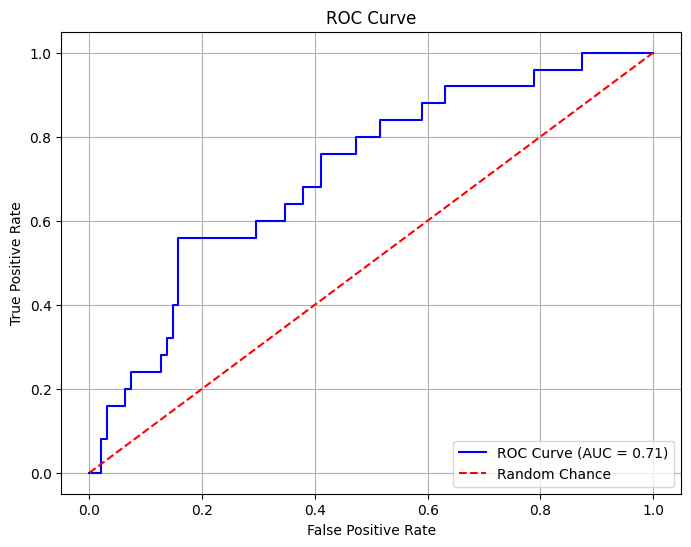

In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.2f}")

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
'''
# Compute and display the ROC AUC score
roc_auc = roc_curve(y_test, y_pred_proba)
print(f"\nROC AUC Score:", roc_auc)

# Plot the ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
'''

## GBOOST (better performance)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


# Calculate class weights
class_counts = np.bincount(y_resampled.astype(int))
total_samples = len(y_resampled)
num_classes = len(class_counts)

class_weights = {}
for i, count in enumerate(class_counts):
    class_weights[i] = total_samples / (num_classes * count)

# Assign weights to each sample
sample_weights = []
for label in y_resampled:
    sample_weights.append(class_weights[int(label)])
sample_weights = np.array(sample_weights)

gbc = GradientBoostingClassifier(random_state=42, loss='log_loss', subsample=0.8, n_estimators=100, learning_rate=0.3, max_depth=7)
gbc.fit(X_resampled, y_resampled, sample_weight=sample_weights)
y_pred = gbc.predict(X_test)

print("Classification Report after SMOTE:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

NOTE:

Parameters;
subsample=0.8, n_estimators=500, learning_rate=0.5, max_depth=9

Provide the following results below:-


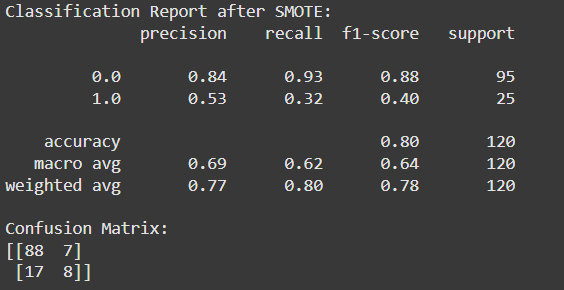

## RFC

In [ ]:
# Train the classifier on the SMOTE-balanced dataset
clf_smote = RandomForestClassifier(n_estimators=300, random_state=42)
clf_smote.fit(X_resampled, y_resampled)
# Predict on the test set
y_pred_smote = clf_smote.predict(X_test)
# Evaluate the model
print("Classification Report (After SMOTE):")
print(classification_report(y_test, y_pred_smote))

Classification Report (After SMOTE):
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85        95
         1.0       0.39      0.28      0.33        25

    accuracy                           0.76       120
   macro avg       0.61      0.58      0.59       120
weighted avg       0.73      0.76      0.74       120





---

